## Modelling of US Adult Census Data to Predict Income
Barış Umut Kürün

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# "sep = ';' is used to divide the data into columns"
df = pd.read_csv('2_Modelling_Question_Dataset.csv', sep = ';')

In [3]:
df.head(10)

,RECORD_ID,AGE,WORKCLASS,FNLWGHT,EDUCATION,EDUCATION_NUM,MARITAL_STATUS,OCCUPATION,RELATIONSHIP,RACE,SEX,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK,COUNTRY,PROXY,TARGET
0,1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0
5,6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,0
6,7,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K,0
7,8,23,Private,122272,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,<=50K,0
8,9,32,Private,205019,Assoc-acdm,12,Never-married,Sales,Not-in-family,Black,Male,0,0,50,United-States,<=50K,0
9,10,34,Private,245487,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,Amer-Indian-Eskimo,Male,0,0,45,Mexico,<=50K,0


In [4]:
# This is used to see main numerical parameters and to see which columns have numerical values.

df.describe()

,RECORD_ID,AGE,FNLWGHT,EDUCATION_NUM,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK,TARGET
count,32561.000000,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,16281.000000,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,0.240810
std,9399.695394,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,0.427581
min,1.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,8141.000000,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,16281.000000,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,24421.000000,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,32561.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [5]:
# Creating a "numeric_columns" for further numeric analysis and 
# discarding "FNLWGHT" and "RECORD_ID" as they are irrelevant in estimating the "TARGET".

numeric_columns = list(set(df.describe().columns) - set(['RECORD_ID', 'FNLWGHT']))

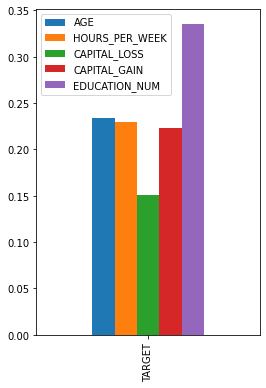

In [6]:
# This figure shows the correlation (pearson correlation by default) of numerical parameteres to the target parameter.

df[numeric_columns].corr().iloc[-1:,:-1].plot.bar(figsize = (4,6))

In [7]:
# The first dimensionalty reduction is to reduce "capital_gain" and "capital_loss" to one "capital_net"
# by subtracting loss from gain.

df['CAPITAL_NET'] = df.CAPITAL_GAIN - df.CAPITAL_LOSS
df.drop(columns = ['CAPITAL_GAIN', 'CAPITAL_LOSS'], inplace = True)

In [8]:
# Categorical(non-numeric) columns are selected for further analysis.

categorical_columns = list(set(df.columns)-set(df.describe().columns))

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

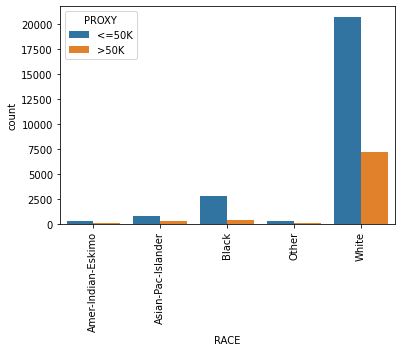

In [9]:
race_counts = df[['RACE', 'PROXY']].groupby(['RACE','PROXY']).size().reset_index(name = 'count')
sns.barplot(x = 'RACE',y = 'count', data = race_counts, hue = 'PROXY')
plt.xticks(rotation = '90')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

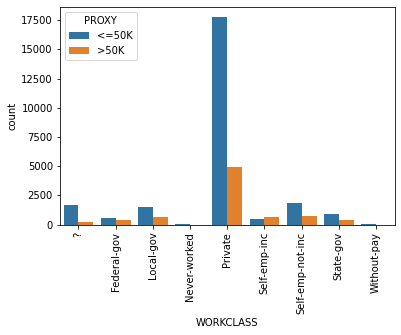

In [10]:
workclass_counts = df[['WORKCLASS', 'PROXY']].groupby(['WORKCLASS','PROXY']).size().reset_index(name = 'count')
sns.barplot(x = 'WORKCLASS',y = 'count', data = workclass_counts, hue = 'PROXY')
plt.xticks(rotation = '90')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

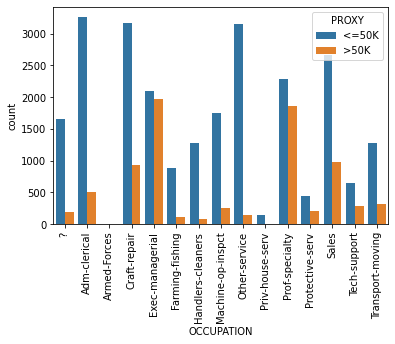

In [11]:
occupation_counts = df[['OCCUPATION', 'PROXY']].groupby(['OCCUPATION','PROXY']).size().reset_index(name = 'count')
sns.barplot(x = 'OCCUPATION',y = 'count', data = occupation_counts, hue = 'PROXY')
plt.xticks(rotation = '90')

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

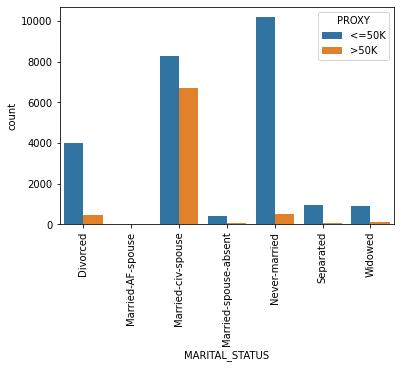

In [12]:
marital_status_counts = df[['MARITAL_STATUS', 'PROXY']].groupby(['MARITAL_STATUS','PROXY']).size().reset_index(name = 'count')
sns.barplot(x = 'MARITAL_STATUS',y = 'count', data = marital_status_counts, hue = 'PROXY')
plt.xticks(rotation = '90')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

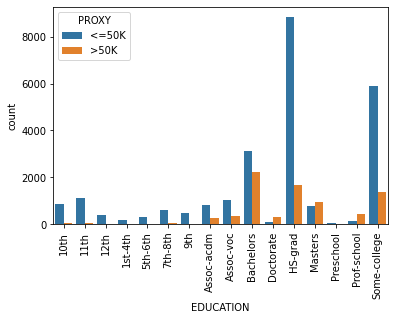

In [13]:
education_counts = df[['EDUCATION', 'PROXY']].groupby(['EDUCATION','PROXY']).size().reset_index(name = 'count')
sns.barplot(x = 'EDUCATION',y = 'count', data = education_counts, hue = 'PROXY')
plt.xticks(rotation = '90')

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

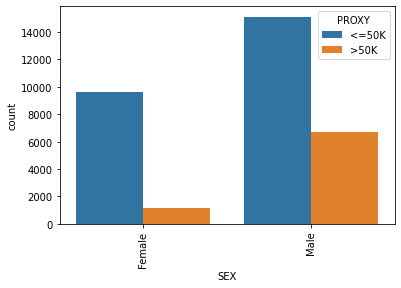

In [14]:
sex_counts = df[['SEX', 'PROXY']].groupby(['SEX','PROXY']).size().reset_index(name = 'count')
sns.barplot(x = 'SEX',y = 'count', data = sex_counts, hue = 'PROXY')
plt.xticks(rotation = '90')

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

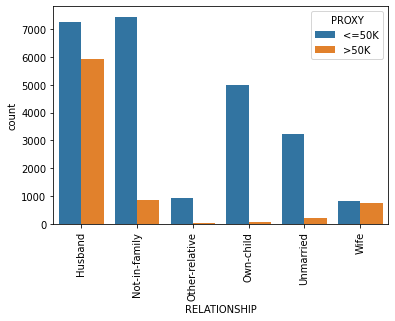

In [15]:
relationship_counts = df[['RELATIONSHIP', 'PROXY']].groupby(['RELATIONSHIP','PROXY']).size().reset_index(name = 'count')
sns.barplot(x = 'RELATIONSHIP',y = 'count', data = relationship_counts, hue = 'PROXY')
plt.xticks(rotation = '90')

In [16]:
# NULL values are examined before further analysis.

df.isnull().count()

RECORD_ID         32561
AGE               32561
WORKCLASS         32561
FNLWGHT           32561
EDUCATION         32561
EDUCATION_NUM     32561
MARITAL_STATUS    32561
OCCUPATION        32561
RELATIONSHIP      32561
RACE              32561
SEX               32561
HOURS_PER_WEEK    32561
COUNTRY           32561
PROXY             32561
TARGET            32561
CAPITAL_NET       32561
dtype: int64

In [17]:
# to find ? which is the "null" in this dataset

for col in categorical_columns:
    df.loc[df[col] =='?', col] = np.nan

In [18]:
# remove nans(?)

df = df.dropna(axis=0, how = 'any')
print(df.shape[0])

30162


In [19]:
# Determining values that effects TARGET.

x_values = ['EDUCATION_NUM', 'HOURS_PER_WEEK', 'AGE', 'CAPITAL_NET', 'RACE', 'RELATIONSHIP', 
            'WORKCLASS', 'SEX', 'COUNTRY','MARITAL_STATUS', 'OCCUPATION']

In [20]:
# Building the test and train set to process data.

X_train, X_test, y_train, y_test = train_test_split(
     df[x_values], df.TARGET, test_size=0.20, random_state=27)

In [21]:
# Data processing:
# Calculate skew and sort, to determine which numerical feature need transformation.
skew_feats = X_train[['EDUCATION_NUM',
 'CAPITAL_NET',
 'HOURS_PER_WEEK',
 'AGE']].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skew_feats})
skewness
# Transformation is needed for only "CAPITAL_NET" 

,Skew
CAPITAL_NET,11.642207
AGE,0.529858
HOURS_PER_WEEK,0.351840
EDUCATION_NUM,-0.311241


In [22]:
# Transformation of capital_net
#X_train.CAPITAL_NET = X_train.CAPITAL_NET.apply(lambda x: np.log(x + 1))
#X_test.CAPITAL_NET = X_test.CAPITAL_NET.apply(lambda x: np.log(x + 1))

In [23]:
# Normalizing numerical_columns variables.

min_max_scaler = MinMaxScaler() 
X_train[['AGE', 'HOURS_PER_WEEK', 'EDUCATION_NUM','CAPITAL_NET']] = min_max_scaler.fit_transform(X_train[['AGE', 'HOURS_PER_WEEK', 'EDUCATION_NUM','CAPITAL_NET']])
X_test[['AGE', 'HOURS_PER_WEEK', 'EDUCATION_NUM','CAPITAL_NET']] = min_max_scaler.fit_transform(X_test[['AGE', 'HOURS_PER_WEEK', 'EDUCATION_NUM','CAPITAL_NET']])


In [24]:
# Creating dummies for categorical_columns variables.

X_train = pd.get_dummies(X_train, prefix_sep='_', drop_first=True)
X_test = pd.get_dummies(X_test, prefix_sep='_', drop_first=True)

In [25]:
#to make equal number of columns.

X_test[list(set(X_train.columns)-set(X_test.columns))[0]]=0

In [26]:
# Logistic Regression:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Logistic Regression accuracy score with all the features: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Logistic Regression accuracy score with all the features: 0.8162


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
# Random Forest:

clf=RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Random Forest accuracy score with all the features: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Random Forest accuracy score with all the features: 0.8104


In [28]:
# XGBoost:

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train[X_test.columns], y_train)
y_pred = xgb_model.predict(X_test)
print('XGBoost accuracy score with all the features: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

XGBoost accuracy score with all the features: 0.8135


In [29]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)
print("Accuracy: %s%%" % (100*accuracy_score(y_test, predictions)))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 80.8055693684734%
[[4554   24]
 [1134  321]]
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      4578
           1       0.93      0.22      0.36      1455

    accuracy                           0.81      6033
   macro avg       0.87      0.61      0.62      6033
weighted avg       0.83      0.81      0.76      6033



# Precision, Recall parameters can be further analyzed.
# Cross Validation Score can be further analyzed for model validation. 
# What to add to parameter with grid search can be improved and iterating parameters for fine-tuning can be done. 